<a href="https://colab.research.google.com/github/kyle-gao/ML_ipynb/blob/master/TransferLearning_TFHUB_DataAug_preprocessingLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Yi Lin(Kyle) Gao

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 .

In [1]:
import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_datasets as tfds


In [2]:
print(tf.__version__)

2.3.0


In [3]:
(train,test), info = tfds.load('tf_flowers', split = ["train[:80%]","train[80%:]"], as_supervised = True, with_info=True)

In [4]:
num_classes = info.features['label'].num_classes

# Data Augmentation with tf.keras.layers.experimental.preprocessing
These can be applied to datasets via .map() or added directly to the model.


In [5]:
resize_and_rescale = preprocessing = tf.keras.Sequential([
                             tf.keras.layers.experimental.preprocessing.Resizing(224,224),
                             tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0)
])

In [6]:
augment = tf.keras.Sequential([
                             tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                             tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2,0.2),
                             tf.keras.layers.experimental.preprocessing.RandomZoom(0.2,0.2)                                                          
])

Pipeline and preprocessing

In [7]:
def preprocessing (ds, batch_size = 32, augment_ds = False, shuffle_ds = False):
  ds = ds.cache()
  if shuffle_ds:
    ds = ds.shuffle(1024)
  ds = ds.padded_batch(batch_size) #use ds.padded_batch() here since images are of different shape before resize_and_resize()
  ds = ds.map((lambda x,y : (resize_and_rescale(x),y)),num_parallel_calls= tf.data.experimental.AUTOTUNE)
  if augment_ds:
    ds = ds.map((lambda x,y : (augment(x),y)),num_parallel_calls= tf.data.experimental.AUTOTUNE)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [8]:
train = preprocessing(train, 32, shuffle_ds = True,augment_ds = True)
test = preprocessing(test, 32)

#Import mobilenet as a tfhub.KerasLayer

In [9]:
mobile_net_features_vec = tfhub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" , input_shape = (224,224,3))

In [10]:
model = tf.keras.Sequential([mobile_net_features_vec,
                             tf.keras.layers.Dense(128, activation = 'relu'),
                             tf.keras.layers.Dense(num_classes, activation = 'softmax')])
model.compile(optimizer = 'adam', loss = "sparse_categorical_crossentropy", metrics = "acc")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 2,422,597
Trainable params: 164,613
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
log = model.fit(train, validation_data=test, epochs = 10, verbose = 1)

Epoch 1/10
92/92 [==============================] - 31s 332ms/step - loss: 0.7570 - acc: 0.7108 - val_loss: 0.4713 - val_acc: 0.8256
Epoch 2/10
92/92 [==============================] - 28s 303ms/step - loss: 0.5306 - acc: 0.8011 - val_loss: 0.3850 - val_acc: 0.8678
Epoch 3/10
92/92 [==============================] - 28s 302ms/step - loss: 0.4749 - acc: 0.8232 - val_loss: 0.4024 - val_acc: 0.8556
Epoch 4/10
92/92 [==============================] - 28s 302ms/step - loss: 0.4692 - acc: 0.8317 - val_loss: 0.4613 - val_acc: 0.8447
Epoch 5/10
92/92 [==============================] - 28s 302ms/step - loss: 0.4470 - acc: 0.8307 - val_loss: 0.3727 - val_acc: 0.8787
Epoch 6/10
92/92 [==============================] - 28s 302ms/step - loss: 0.4020 - acc: 0.8569 - val_loss: 0.3490 - val_acc: 0.8856
Epoch 7/10
92/92 [==============================] - 28s 302ms/step - loss: 0.4029 - acc: 0.8379 - val_loss: 0.3383 - val_acc: 0.8896
Epoch 8/10
92/92 [==============================] - 28s 301ms/step - 

# We compare with a convolutional model.

In [27]:
conv = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu',input_shape = (224,224,3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation = 'softmax')
])
conv.compile(optimizer = 'Adam', loss = "sparse_categorical_crossentropy", metrics = "acc")
conv.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               25690240  
_________________________________________________________________
dense_15 (Dense)             (None, 5)                

In [28]:
log2 = conv.fit(train, validation_data=test, epochs = 10, verbose = 1)

Epoch 1/10
      2/Unknown - 0s 58ms/step - loss: 4.1507 - acc: 0.2188WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0481s). Check your callbacks.


92/92 [==============================] - 28s 309ms/step - loss: 1.6895 - acc: 0.3566 - val_loss: 1.2723 - val_acc: 0.4809
Epoch 2/10
92/92 [==============================] - 29s 311ms/step - loss: 1.2862 - acc: 0.4431 - val_loss: 1.2307 - val_acc: 0.4768
Epoch 3/10
92/92 [==============================] - 28s 309ms/step - loss: 1.1989 - acc: 0.5058 - val_loss: 1.1092 - val_acc: 0.5518
Epoch 4/10
92/92 [==============================] - 28s 309ms/step - loss: 1.1238 - acc: 0.5283 - val_loss: 1.0323 - val_acc: 0.5995
Epoch 5/10
92/92 [==============================] - 28s 305ms/step - loss: 1.0729 - acc: 0.5616 - val_loss: 1.0472 - val_acc: 0.5926
Epoch 6/10
92/92 [==============================] - 28s 310ms/step - loss: 1.0472 - acc: 0.5858 - val_loss: 0.9867 - val_acc: 0.5886
Epoch 7/10
92/92 [==============================] - 28s 309ms/step - loss: 1.0208 - acc: 0.6001 - val_loss: 1.0516 - val_acc: 0.5777
Epoch 8/10
92/92 [==============================] - 28s 305ms/step - loss: 0.973

In [30]:
import matplotlib.pyplot as plt

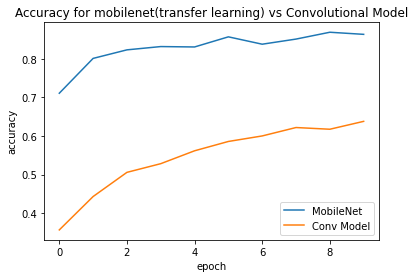

In [41]:
plt.plot(log.history['acc'],label="MobileNet")
plt.plot(log2.history['acc'],label="Conv Model")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy for mobilenet(transfer learning) vs Convolutional Model")
plt.show()

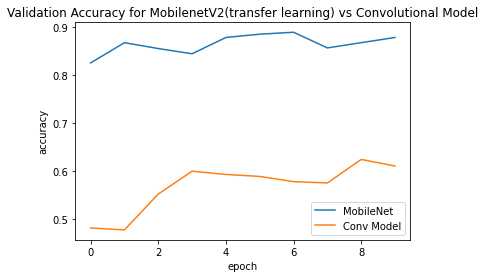

In [42]:
plt.plot(log.history['val_acc'],label="MobileNet")
plt.plot(log2.history['val_acc'],label="Conv Model")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Validation Accuracy for MobilenetV2(transfer learning) vs Convolutional Model")
plt.show()